In [0]:
from pyspark import SparkContext
from pyspark.sql import Window, Row, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [0]:
# create dataframes from each CSV file
teams_df = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/brijeshpatel4547@gmail.com/Teams.csv")

#matches_df = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/brijeshpatel4547@gmail.com/Matches.csv")

teams_in_matches_df = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/brijeshpatel4547@gmail.com/Teams_in_Matches.csv")

unique_teams_df = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/brijeshpatel4547@gmail.com/Unique_Teams.csv")

In [0]:
matches_df = spark.read.format("csv").option("header", "true").option("inferSchema","true").load("dbfs:/FileStore/shared_uploads/brijeshpatel4547@gmail.com/Matches.csv")

matches_df.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [0]:
# Rename the last three column names
old_cols = matches_df.columns[-3:]
new_cols = ['HomeTeamGoals','AwayTeamGoals','FinalResult']
cols_tuple = [*zip(old_cols,new_cols)]
for old_cols,new_cols in cols_tuple:
    matches_df = matches_df.withColumnRenamed(old_cols,new_cols)

matches_df.limit(5).show()

['FTHG', 'FTAG', 'FTR']
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|            1|            3|          A|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+



In [0]:
matches_df.limit(5).toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,HomeTeamGoals,AwayTeamGoals,FinalResult,HomeTeamWin,AwayTeamWin,GameTie
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H,1,0,0
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A,0,1,0
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D,0,0,1
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H,1,0,0
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A,0,1,0


In [0]:
#Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000–2010?
# Add 3 columns into matches_df which Shows Home Team Wins, Away Team Wins and Tied Games
matches_df = matches_df \
    .withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
    .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
    .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))

# D1 Division = Bundesliga => Filter the matches dataframe and get the D1 matches between 2000 and 2010
bundesliga_df = matches_df.filter((col('Div') == 'D1') & 
                         (col('Season') >= '2000') & (col('Season') <= '2010')                        
                         )

bundesliga_df.show(5)

In [0]:
# Home team fixtures
home_df = bundesliga_df.groupBy("Season","HomeTeam") \
            .agg(sum('HomeTeamWin').alias('HomeWins'), \
                sum('AwayTeamWin').alias('HomeLosses'), \
                sum('GameTie').alias("HomeDraws"),   \
                sum('HomeTeamGoals').alias("HomeGoalsScored"), \
                sum('AwayTeamGoals').alias("HomeGoalsConceded") ) \
            .withColumnRenamed('HomeTeam','Team') \
            .orderBy('Season','Team')
home_df.show(5)


+------+-------------+--------+----------+---------+---------------+-----------------+
|Season|         Team|HomeWins|HomeLosses|HomeDraws|HomeGoalsScored|HomeGoalsConceded|
+------+-------------+--------+----------+---------+---------------+-----------------+
|  2000|Bayern Munich|      12|         4|        1|             37|               20|
|  2000|       Bochum|       5|         8|        4|             20|               28|
|  2000|      Cottbus|      10|         6|        1|             27|               20|
|  2000|     Dortmund|       9|         4|        4|             34|               20|
|  2000|Ein Frankfurt|       8|         6|        3|             26|               22|
+------+-------------+--------+----------+---------+---------------+-----------------+
only showing top 5 rows



In [0]:
# Away Team Fixtures
away_df = bundesliga_df.groupBy("Season","AwayTeam") \
            .agg(sum('AwayTeamWin').alias('AwayWins'), \
                sum('HomeTeamWin').alias('AwayLosses'), \
                sum('GameTie').alias("AwayDraws"),   \
                sum('AwayTeamGoals').alias("AwayGoalsScored"), \
                sum('HomeTeamGoals').alias("AwayGoalsConceded") ) \
            .withColumnRenamed('AwayTeam','Team') \
            .orderBy('Season','Team')
away_df.show(5)

+------+-------------+--------+----------+---------+---------------+-----------------+
|Season|         Team|AwayWins|AwayLosses|AwayDraws|AwayGoalsScored|AwayGoalsConceded|
+------+-------------+--------+----------+---------+---------------+-----------------+
|  2000|Bayern Munich|       7|         5|        5|             25|               17|
|  2000|       Bochum|       2|        13|        2|             10|               39|
|  2000|      Cottbus|       2|        13|        2|             11|               32|
|  2000|     Dortmund|       7|         4|        6|             28|               22|
|  2000|Ein Frankfurt|       2|        13|        2|             15|               46|
+------+-------------+--------+----------+---------+---------------+-----------------+
only showing top 5 rows



In [0]:
# Join Home and Away on Team and Season:
window = Window.partitionBy("Season")\
            .orderBy(col('Win%').desc(), col('GoalDifference').desc())

final_df = home_df.join(away_df,['Team','Season'],'inner') \
            .withColumn('GoalsScored',col('HomeGoalsScored') + col('AwayGoalsScored')) \
            .withColumn('GoalsConceded',col('HomeGoalsConceded') + col('AwayGoalsConceded')) \
            .withColumn('GoalDifference',col('GoalsScored') - col('GoalsConceded')) \
            .withColumn('TotalWins', col('HomeWins') + col('AwayWins')) \
            .withColumn('TotalLosses', col('HomeLosses') + col('AwayLosses')) \
            .withColumn('TotalDraws', col('HomeDraws') + col('AwayDraws')) \
            .withColumn('Win%',round((100 * col('TotalWins')/(col('TotalWins')+col('TotalLosses')+col('TotalDraws'))),2)) \
            .drop('HomeGoalsScored','AwayGoalsScored','HomeGoalsConceded','AwayGoalsConceded','HomeWins','AwayWins','HomeLosses') \
            .drop('AwayLosses','HomeDraws','AwayDraws') \
            .withColumn('Position',rank().over(window))

winners = final_df.filter(col('Position') == '1').orderBy(asc('Season')).toPandas()
winners


,Team,Season,GoalsScored,GoalsConceded,GoalDifference,TotalWins,TotalLosses,TotalDraws,Win%,Position
0,Bayern Munich,2000,62,37,25,19,9,6,55.88,1
1,Leverkusen,2001,77,38,39,21,7,6,61.76,1
2,Bayern Munich,2002,70,25,45,23,5,6,67.65,1
3,Werder Bremen,2003,79,38,41,22,4,8,64.71,1
4,Bayern Munich,2004,75,33,42,24,5,5,70.59,1
5,Bayern Munich,2005,67,32,35,22,3,9,64.71,1
6,Stuttgart,2006,61,37,24,21,6,7,61.76,1
7,Bayern Munich,2007,68,21,47,22,2,10,64.71,1
8,Wolfsburg,2008,80,41,39,21,7,6,61.76,1
9,Bayern Munich,2009,72,31,41,20,4,10,58.82,1


In [0]:
# Total Championships wons by each team in D1 and between 2000-2010
q2_df = final_df.filter(col('Position') == '1').groupBy('Team') \
            .agg(count('Team').alias("Total_Championships"),
                 avg('Win%').alias('AvgWin%'),
                 avg('GoalDifference').alias('AvgGD'),
                 avg('TotalWins').alias('AvgWins'),
                 avg('TotalLosses').alias('AvgLosses'),
                 avg('TotalDraws').alias('AvgDraws')) \
            .orderBy(desc("Total_Championships"))
q2_df.toPandas().round(1)

,Team,Total_Championships,AvgWin%,AvgGD,AvgWins,AvgLosses,AvgDraws
0,Bayern Munich,6,63.7,39.2,21.7,4.7,7.7
1,Werder Bremen,1,64.7,41.0,22.0,4.0,8.0
2,Leverkusen,1,61.8,39.0,21.0,7.0,6.0
3,Wolfsburg,1,61.8,39.0,21.0,7.0,6.0
4,Stuttgart,1,61.8,24.0,21.0,6.0,7.0
5,Dortmund,1,67.6,45.0,23.0,5.0,6.0


In [0]:
#Which teams have been relegated in the past 2000 - 2010 years season wise?
relegated = final_df.filter((col('position') == 16) | (col('position') == 17) | (col('position') == 18)).orderBy('Season')
relegated.limit(5).toPandas()


,Team,Season,GoalsScored,GoalsConceded,GoalDifference,TotalWins,TotalLosses,TotalDraws,Win%,Position
0,Stuttgart,2000,42,49,-7,9,14,11,26.47,16
1,Unterhaching,2000,35,59,-24,8,15,11,23.53,17
2,Bochum,2000,30,67,-37,7,21,6,20.59,18
3,Freiburg,2001,37,64,-27,7,18,9,20.59,16
4,FC Koln,2001,26,61,-35,7,19,8,20.59,17


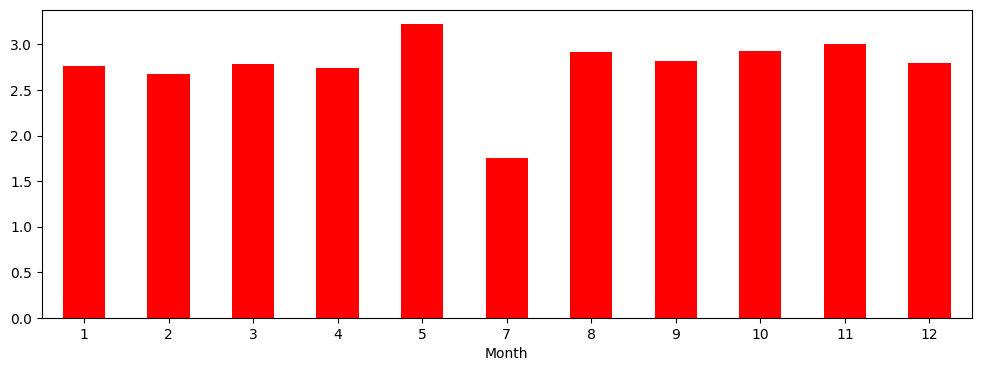

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-779556864075812>, line 20
     18 oktoberfest_df['GoalsPerGameRatio'].plot.bar(rot=0, color='red', figsize=(12, 4))
     19 #plt.ylabel('GoalsPerGameRatio')
---> 20 plt.show()

File /databricks/python/lib/python3.10/site-packages/matplotlib/_api/__init__.py:226, in caching_module_getattr.<locals>.__getattr__(name)
    224 if name in props:
    225     return props[name].__get__(instance)
--> 226 raise AttributeError(
    227     f"module {cls.__module__!r} has no attribute {name!r}")

AttributeError: module 'matplotlib' has no attribute 'show'

In [0]:
# Does Oktoberfest have any effect on the performance of the overall league?
import plotly as py
import matplotlib as plt
oktoberfest = matches_df.filter((col('Div') == 'D1') & (col('Season') >= 2000) & (col('Season') <= 2010) ) \
                       .withColumn('Month', month(col('Date'))) \
                       .groupBy('Month') \
                       .agg(sum(col('HomeTeamGoals')+col('AwayTeamGoals')).alias('Goals'),
                            sum('GameTie').alias('GameTies'),
                            count(col('FinalResult')).alias('Total')) \
                       .withColumn('GoalsPerGameRatio', round(col('Goals')/col('Total'),2)) \
                       .withColumn('TiesPerGameRatio',round(col('GameTies')/col('Total'),2))

oktoberfest_df = oktoberfest.toPandas()

oktoberfest_df = oktoberfest_df.sort_values('Month')
#oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['GoalsPerGameRatio'].plot.bar(rot=0, color='red', figsize=(12, 4))
#plt.ylabel('GoalsPerGameRatio')
plt.show()
                        
                        

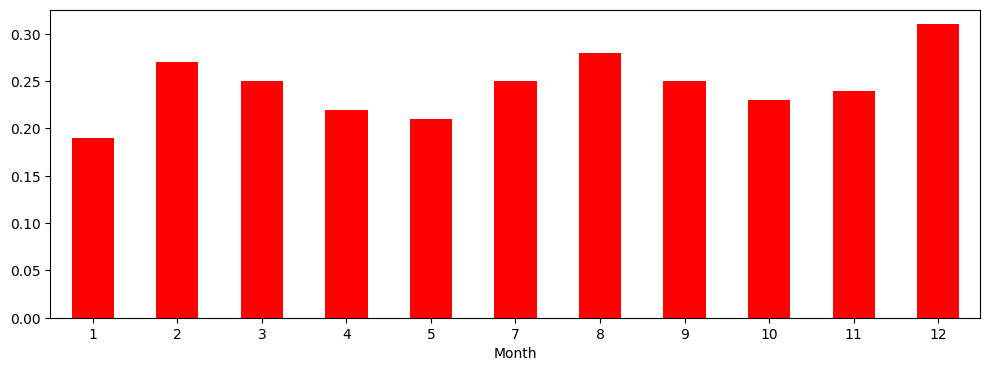

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-779556864075813>, line 2
      1 oktoberfest_df['TiesPerGameRatio'].plot.bar(rot=0, color='red', figsize=(12, 4))
----> 2 plt.ylabel('TiesPerGameRatio')
      3 plt.show()

File /databricks/python/lib/python3.10/site-packages/matplotlib/_api/__init__.py:226, in caching_module_getattr.<locals>.__getattr__(name)
    224 if name in props:
    225     return props[name].__get__(instance)
--> 226 raise AttributeError(
    227     f"module {cls.__module__!r} has no attribute {name!r}")

AttributeError: module 'matplotlib' has no attribute 'ylabel'

In [0]:
oktoberfest_df['TiesPerGameRatio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.ylabel('TiesPerGameRatio')
plt.show()

In [0]:
# Which season of Bundesliga was the most competitive in the last decade?
df1 = bundesliga_df.groupBy('Season') \
                       .agg(sum(col('HomeTeamGoals')+col('AwayTeamGoals')).alias('Goals'),
                            sum('GameTie').alias('GameTies'),
                            count(col('FinalResult')).alias('Total')) \
                       .withColumn('GoalsPerGameRatio', round(col('Goals')/col('Total'),2)) \
                       .withColumn('TiesPerGameRatio',round(col('GameTies')/col('Total'),2)) \
                       .orderBy(desc('GoalsPerGameRatio'),desc('TiesPerGameRatio'))
df1.limit(5).show()

+------+-----+--------+-----+-----------------+----------------+
|Season|Goals|GameTies|Total|GoalsPerGameRatio|TiesPerGameRatio|
+------+-----+--------+-----+-----------------+----------------+
|  2003|  909|      72|  306|             2.97|            0.24|
|  2000|  897|      69|  306|             2.93|            0.23|
|  2008|  894|      74|  306|             2.92|            0.24|
|  2001|  893|      68|  306|             2.92|            0.22|
|  2010|  894|      63|  306|             2.92|            0.21|
+------+-----+--------+-----+-----------------+----------------+



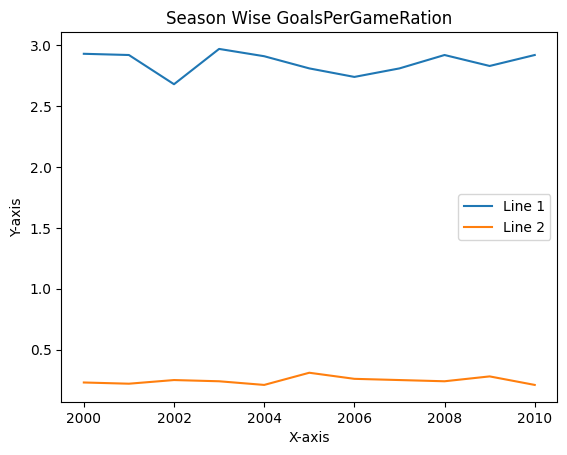

In [0]:
import matplotlib.pyplot as pl
q4_df = df1.orderBy(col('Season')).toPandas()
# Plot a simple line chart
pl.plot(q4_df['Season'], q4_df['GoalsPerGameRatio'], label='Line 1')  # Plot the first line
pl.plot(q4_df['Season'], q4_df['TiesPerGameRatio'], label='Line 2')  # Plot the second line

# Customize the plot (optional)
pl.title("Season Wise GoalsPerGameRation")
pl.xlabel("X-axis")
pl.ylabel("Y-axis")
pl.legend()  # Show legend with labels for each line

# Display the plot
pl.show()

In [0]:
# What's the best month to watch Bundesliga?
df2 = bundesliga_df.withColumn('Month', month(col('Date'))) \
                       .groupBy('Month')\
                       .agg(sum(col('HomeTeamGoals')+col('AwayTeamGoals')).alias('Goals'),
                            sum('GameTie').alias('GameTies'),
                            count(col('FinalResult')).alias('Total')) \
                       .withColumn('GoalsPerGameRatio', round(col('Goals')/col('Total'),2)) \
                       .withColumn('TiesPerGameRatio',round(col('GameTies')/col('Total'),2)) \
                       .orderBy('Month')
df2.limit(5).show()

+-----+-----+--------+-----+-----------------+----------------+
|Month|Goals|GameTies|Total|GoalsPerGameRatio|TiesPerGameRatio|
+-----+-----+--------+-----+-----------------+----------------+
|    1|  386|      27|  140|             2.76|            0.19|
|    2| 1108|     110|  415|             2.67|            0.27|
|    3| 1076|      96|  386|             2.79|            0.25|
|    4| 1138|      90|  416|             2.74|            0.22|
|    5|  993|      65|  308|             3.22|            0.21|
+-----+-----+--------+-----+-----------------+----------------+



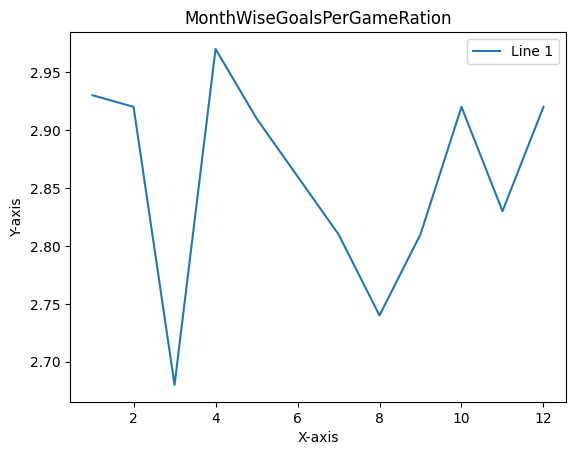

In [0]:
q5_df = df2.toPandas()
# Plot a simple line chart
pl.plot(q5_df['Month'], q4_df['GoalsPerGameRatio'], label='Line 1')  # Plot the first line
#pl.plot(q4_df['Month'], q4_df['TiesPerGameRatio'], label='Line 2')  # Plot the second line

# Customize the plot (optional)
pl.title("MonthWiseGoalsPerGameRation")
pl.xlabel("X-axis")
pl.ylabel("Y-axis")

# Display the plot
pl.show()

#As we see the 4th month

In [0]:
#